In [2]:
# %pip install 'etna[all]'
# %pip install lightgbm xgboost
# %pip install pandas

In [3]:
import pandas as pd

from etna.datasets.tsdataset import TSDataset
from etna.transforms import (
    StandardScalerTransform,
    MeanTransform, 
    LagTransform,
    DateFlagsTransform)

from etna.pipeline import Pipeline
from etna.metrics import SMAPE

import warnings
warnings.filterwarnings('ignore')

from etna.analysis import plot_forecast

In [4]:
HORIZON = 90

smape = SMAPE()

In [5]:
def train_and_evaluate_model(ts, 
                             model,
                             transforms,
                             horizon,
                             metrics,
                             print_metrics=True,
                             return_forecast=False,
                             n_train_samples=0):
    """"
    Обучает модель, вычисляет прогнозы для 
    тестовой выборки и строит график прогнозов. 
    """

    train_ts, test_ts = ts.train_test_split(test_size=horizon)
    pipe = Pipeline(model=model,
                    transforms=transforms,
                    horizon=horizon)
    pipe.fit(train_ts)
    forecast_ts = pipe.forecast()

    # оцениваем качество прогнозов по сегментам
    segment_metrics = metrics(test_ts, forecast_ts)
    segment_metrics = pd.Series(segment_metrics)
    
    avg_metric = sum(segment_metrics) / len(segment_metrics)
    
    if print_metrics:
        print(f"Avg (by segments) metric {metrics} is: {avg_metric}")
    
    if n_train_samples > 0:
        plot_forecast(forecast_ts, test_ts, 
                      train_ts, n_train_samples=n_train_samples)

    if return_forecast:
        return segment_metrics, avg_metric, forecast_ts
    
    return segment_metrics, avg_metric

In [6]:
df = pd.read_csv('../../Data/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])

df.rename(columns={'date': 'timestamp', 
                   'sales': 'target'}, inplace=True)
df

,timestamp,store,item,target
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [7]:
df_new = pd.read_csv('../../Data/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])

df_new.rename(columns={'date': 'timestamp', 
                   'sales': 'target'}, inplace=True)


df_new.drop(columns='id', inplace=True)

df_new

,timestamp,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
...,...,...,...
44995,2018-03-27,10,50
44996,2018-03-28,10,50
44997,2018-03-29,10,50
44998,2018-03-30,10,50


In [8]:
df['segment'] = (df['store'].astype(str) + ' + ' 
                 + df['item'].astype(str))

df_new['segment'] = (df_new['store'].astype(str) + ' + ' 
                     + df_new['item'].astype(str))

df.head()

,timestamp,store,item,target,segment
0,2013-01-01,1,1,13,1 + 1
1,2013-01-02,1,1,11,1 + 1
2,2013-01-03,1,1,14,1 + 1
3,2013-01-04,1,1,13,1 + 1
4,2013-01-05,1,1,10,1 + 1


In [9]:
for col in ['store', 'item']:
    df[col] = df[col].astype('category')
    df_new[col] = df_new[col].astype('category')

In [10]:
regressor_df = df[['timestamp', 'segment', 'store', 'item']].copy()
regressor_df

,timestamp,segment,store,item
0,2013-01-01,1 + 1,1,1
1,2013-01-02,1 + 1,1,1
2,2013-01-03,1 + 1,1,1
3,2013-01-04,1 + 1,1,1
4,2013-01-05,1 + 1,1,1
...,...,...,...,...
912995,2017-12-27,10 + 50,10,50
912996,2017-12-28,10 + 50,10,50
912997,2017-12-29,10 + 50,10,50
912998,2017-12-30,10 + 50,10,50


In [11]:
# экзогенных переменные store и item
regressor_df_new = df_new.copy()
regressor_df_new

,timestamp,store,item,segment
0,2018-01-01,1,1,1 + 1
1,2018-01-02,1,1,1 + 1
2,2018-01-03,1,1,1 + 1
3,2018-01-04,1,1,1 + 1
4,2018-01-05,1,1,1 + 1
...,...,...,...,...
44995,2018-03-27,10,50,10 + 50
44996,2018-03-28,10,50,10 + 50
44997,2018-03-29,10,50,10 + 50
44998,2018-03-30,10,50,10 + 50


In [12]:
regressor_df = regressor_df.sort_index(
    axis=1, ascending=False)

regressor_df_new = regressor_df_new.sort_index(
    axis=1, ascending=False)

In [13]:
regressor_df.shape, regressor_df_new.shape, regressor_df.shape[0] + regressor_df_new.shape[0]

((913000, 4), (45000, 4), 958000)

In [14]:
regressor_df.columns, regressor_df_new.columns

(Index(['timestamp', 'store', 'segment', 'item'], dtype='object'),
 Index(['timestamp', 'store', 'segment', 'item'], dtype='object'))

In [15]:
regressor_df = pd.concat([regressor_df, regressor_df_new], axis=0)

regressor_df['quarter'] = regressor_df['timestamp'].dt.quarter
regressor_df['quarter_start'] = regressor_df['timestamp'].dt.is_quarter_start
regressor_df['quarter_end'] = regressor_df['timestamp'].dt.is_quarter_end
regressor_df

,timestamp,store,segment,item,quarter,quarter_start,quarter_end
0,2013-01-01,1,1 + 1,1,1,True,False
1,2013-01-02,1,1 + 1,1,1,False,False
2,2013-01-03,1,1 + 1,1,1,False,False
3,2013-01-04,1,1 + 1,1,1,False,False
4,2013-01-05,1,1 + 1,1,1,False,False
...,...,...,...,...,...,...,...
44995,2018-03-27,10,10 + 50,50,1,False,False
44996,2018-03-28,10,10 + 50,50,1,False,False
44997,2018-03-29,10,10 + 50,50,1,False,False
44998,2018-03-30,10,10 + 50,50,1,False,False


In [16]:
# подготавливаем исторический набор эндогенных переменных
df.drop(['store', 'item'], axis=1, inplace=True)
df

,timestamp,target,segment
0,2013-01-01,13,1 + 1
1,2013-01-02,11,1 + 1
2,2013-01-03,14,1 + 1
3,2013-01-04,13,1 + 1
4,2013-01-05,10,1 + 1
...,...,...,...
912995,2017-12-27,63,10 + 50
912996,2017-12-28,59,10 + 50
912997,2017-12-29,74,10 + 50
912998,2017-12-30,62,10 + 50


In [17]:
df = TSDataset.to_dataset(df)
df

segment,1 + 1,1 + 10,1 + 11,1 + 12,1 + 13,1 + 14,1 + 15,1 + 16,1 + 17,1 + 18,...,9 + 46,9 + 47,9 + 48,9 + 49,9 + 5,9 + 50,9 + 6,9 + 7,9 + 8,9 + 9
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,34,6,28,11,9,36,29,30,45,27
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,28,14,38,16,11,44,33,24,43,36
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,41,18,24,20,8,29,19,35,34,25
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,41,15,30,19,15,43,33,35,41,31
2013-01-05,10,35,45,46,49,31,47,22,16,56,...,42,13,33,16,13,53,36,28,49,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,14,55,43,47,49,42,62,16,29,54,...,49,19,41,26,18,52,39,44,52,44
2017-12-28,19,63,64,49,68,51,82,24,13,69,...,42,23,36,37,18,73,56,54,76,48


In [18]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df

segment    1 + 1                                         1 + 10          \
feature     item quarter quarter_end quarter_start store   item quarter   
timestamp                                                                 
2013-01-01     1       1       False          True     1     10       1   
2013-01-02     1       1       False         False     1     10       1   
2013-01-03     1       1       False         False     1     10       1   
2013-01-04     1       1       False         False     1     10       1   
2013-01-05     1       1       False         False     1     10       1   
...          ...     ...         ...           ...   ...    ...     ...   
2018-03-27     1       1       False         False     1     10       1   
2018-03-28     1       1       False         False     1     10       1   
2018-03-29     1       1       False         False     1     10       1   
2018-03-30     1       1       False         False     1     10       1   
2018-03-31     1       1        True         False     1     10       1   

segment                                     ... 9 + 8                      \
feature    quarter_end quarter_start store  ...  item quarter quarter_end   
timestamp                                   ...                             
2013-01-01       False          True     1  ...     8       1       False   
2013-01-02       False         False     1  ...     8       1       False   
2013-01-03       False         False     1  ...     8       1       False   
2013-01-04       False         False     1  ...     8       1       False   
2013-01-05       False         False     1  ...     8       1       False   
...                ...           ...   ...  ...   ...     ...         ...   
2018-03-27       False         False     1  ...     8       1       False   
2018-03-28       False         False     1  ...     8       1       False   
2018-03-29       False         False     1  ...     8       1       False   
2018-03-30       False         False     1  ...     8       1       False   
2018-03-31        True         False     1  ...     8       1        True   

segment                        9 + 9                                          
feature    quarter_start store  item quarter quarter_end quarter_start store  
timestamp                                                                     
2013-01-01          True     9     9       1       False          True     9  
2013-01-02         False     9     9       1       False         False     9  
2013-01-03         False     9     9       1       False         False     9  
2013-01-04         False     9     9       1       False         False     9  
2013-01-05         False     9     9       1       False         False     9  
...                  ...   ...   ...     ...         ...           ...   ...  
2018-03-27         False     9     9       1       False         False     9  
2018-03-28         False     9     9       1       False         False     9  
2018-03-29         False     9     9       1       False         False     9  
2018-03-30         False     9     9       1       False         False     9  
2018-03-31         False     9     9       1        True         False     9  

[1916 rows x 2500 columns]

In [19]:
# создаем объединенный набор
ts = TSDataset(df=df, freq='D', df_exog=regressor_df, 
               known_future='all')
ts

segment    1 + 1                                                1 + 10  \
feature     item quarter quarter_end quarter_start store target   item   
timestamp                                                                
2013-01-01     1       1       False          True     1   13.0     10   
2013-01-02     1       1       False         False     1   11.0     10   
2013-01-03     1       1       False         False     1   14.0     10   
2013-01-04     1       1       False         False     1   13.0     10   
2013-01-05     1       1       False         False     1   10.0     10   
...          ...     ...         ...           ...   ...    ...    ...   
2017-12-27     1       4       False         False     1   14.0     10   
2017-12-28     1       4       False         False     1   19.0     10   
2017-12-29     1       4       False         False     1   15.0     10   
2017-12-30     1       4       False         False     1   27.0     10   
2017-12-31     1       4        True         False     1   23.0     10   

segment                                       ...       9 + 8                \
feature    quarter quarter_end quarter_start  ... quarter_end quarter_start   
timestamp                                     ...                             
2013-01-01       1       False          True  ...       False          True   
2013-01-02       1       False         False  ...       False         False   
2013-01-03       1       False         False  ...       False         False   
2013-01-04       1       False         False  ...       False         False   
2013-01-05       1       False         False  ...       False         False   
...            ...         ...           ...  ...         ...           ...   
2017-12-27       4       False         False  ...       False         False   
2017-12-28       4       False         False  ...       False         False   
2017-12-29       4       False         False  ...       False         False   
2017-12-30       4       False         False  ...       False         False   
2017-12-31       4        True         False  ...        True         False   

segment                 9 + 9                                                 
feature    store target  item quarter quarter_end quarter_start store target  
timestamp                                                                     
2013-01-01     9   45.0     9       1       False          True     9   27.0  
2013-01-02     9   43.0     9       1       False         False     9   36.0  
2013-01-03     9   34.0     9       1       False         False     9   25.0  
2013-01-04     9   41.0     9       1       False         False     9   31.0  
2013-01-05     9   49.0     9       1       False         False     9   30.0  
...          ...    ...   ...     ...         ...           ...   ...    ...  
2017-12-27     9   52.0     9       4       False         False     9   44.0  
2017-12-28     9   76.0     9       4       False         False     9   48.0  
2017-12-29     9   73.0     9       4       False         False     9   54.0  
2017-12-30     9   74.0     9       4       False         False     9   59.0  
2017-12-31     9   92.0     9       4        True         False     9   50.0  

[1826 rows x 3000 columns]

# Small Analysis of the Data

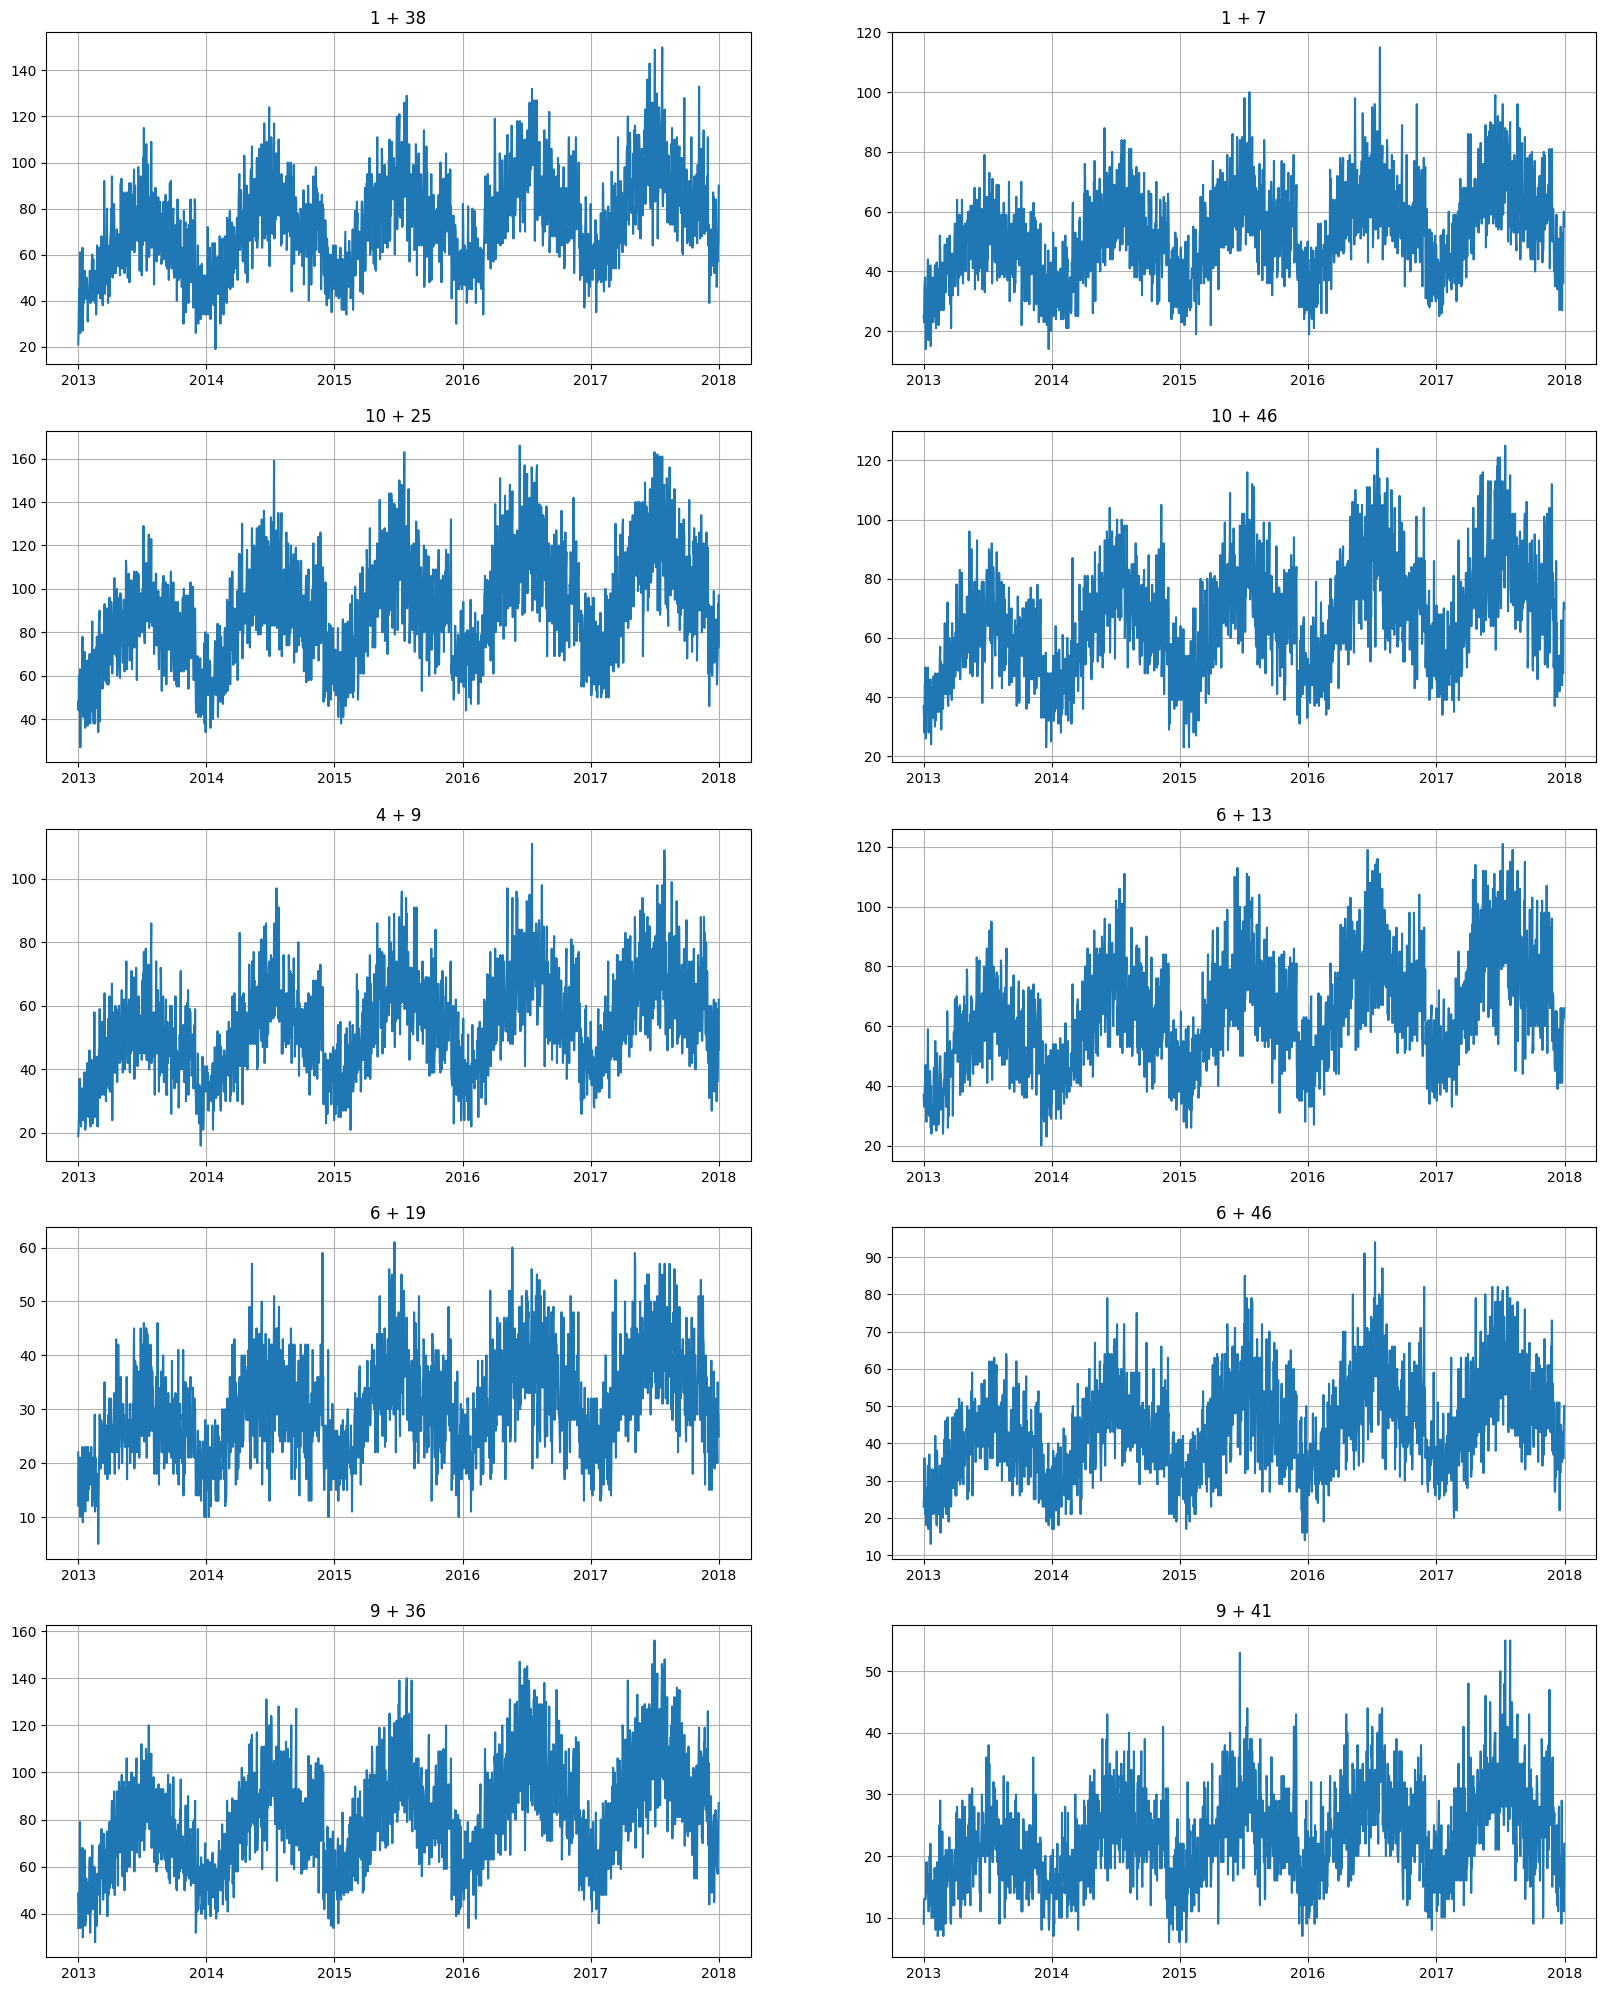

In [20]:
ts.plot()

In [21]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
1 + 1,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
1 + 10,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
1 + 11,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
1 + 12,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
1 + 13,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
...,...,...,...,...,...,...,...,...,...
9 + 50,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
9 + 6,2013-01-01,2017-12-31,1826,0,500,5,5,5,D
9 + 7,2013-01-01,2017-12-31,1826,0,500,5,5,5,D


In [22]:
from etna.analysis import acf_plot
from etna.analysis import plot_correlation_matrix

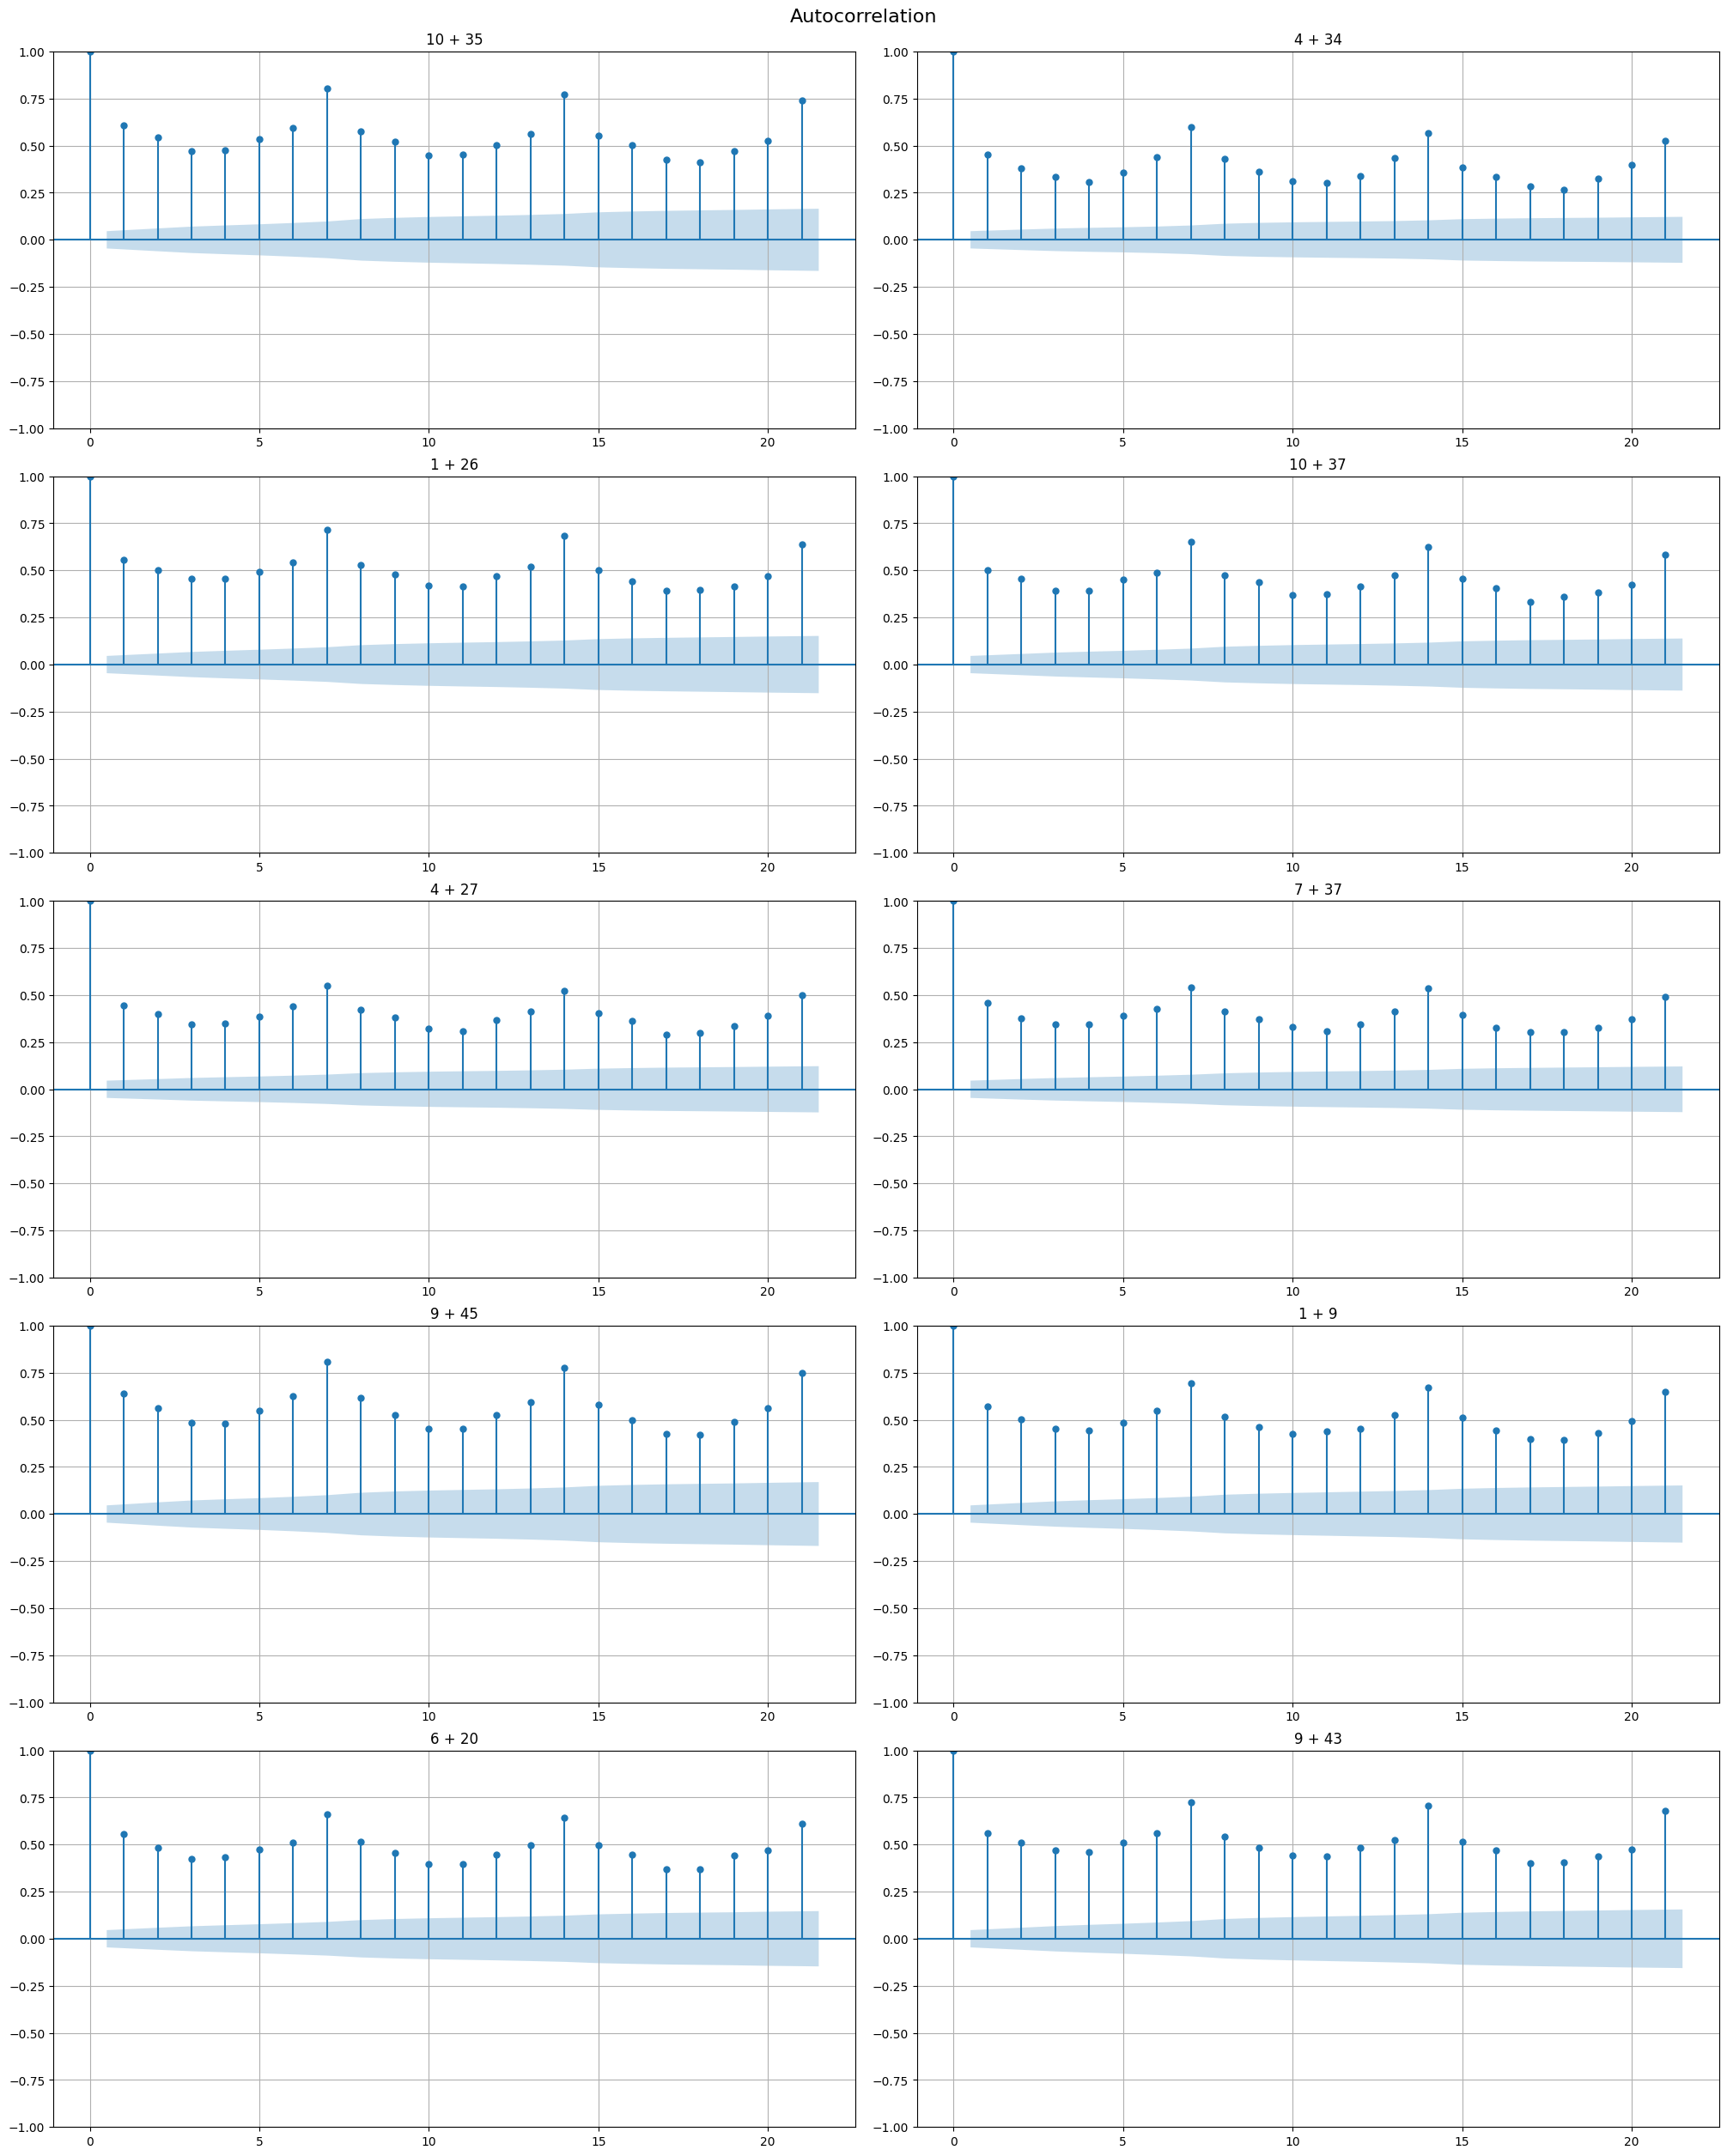

In [23]:
acf_plot(ts, lags=21)

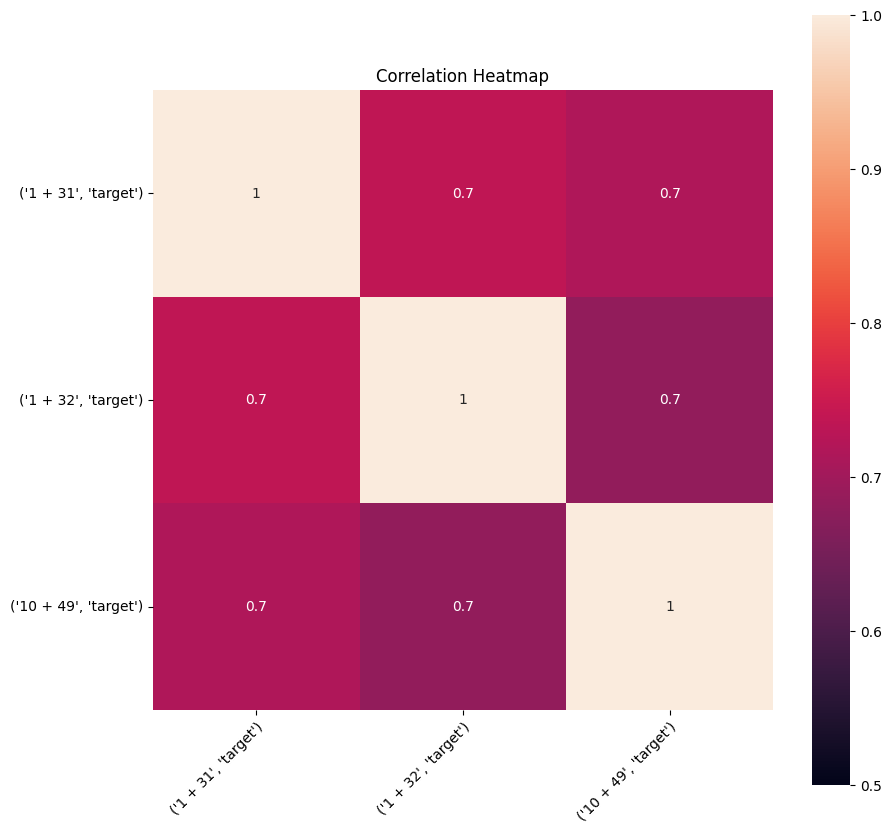

In [24]:
plot_correlation_matrix(ts, columns=['target'], segments=['1 + 31', "1 + 32", "10 + 49"], method="spearman", vmin=0.5, vmax=1)

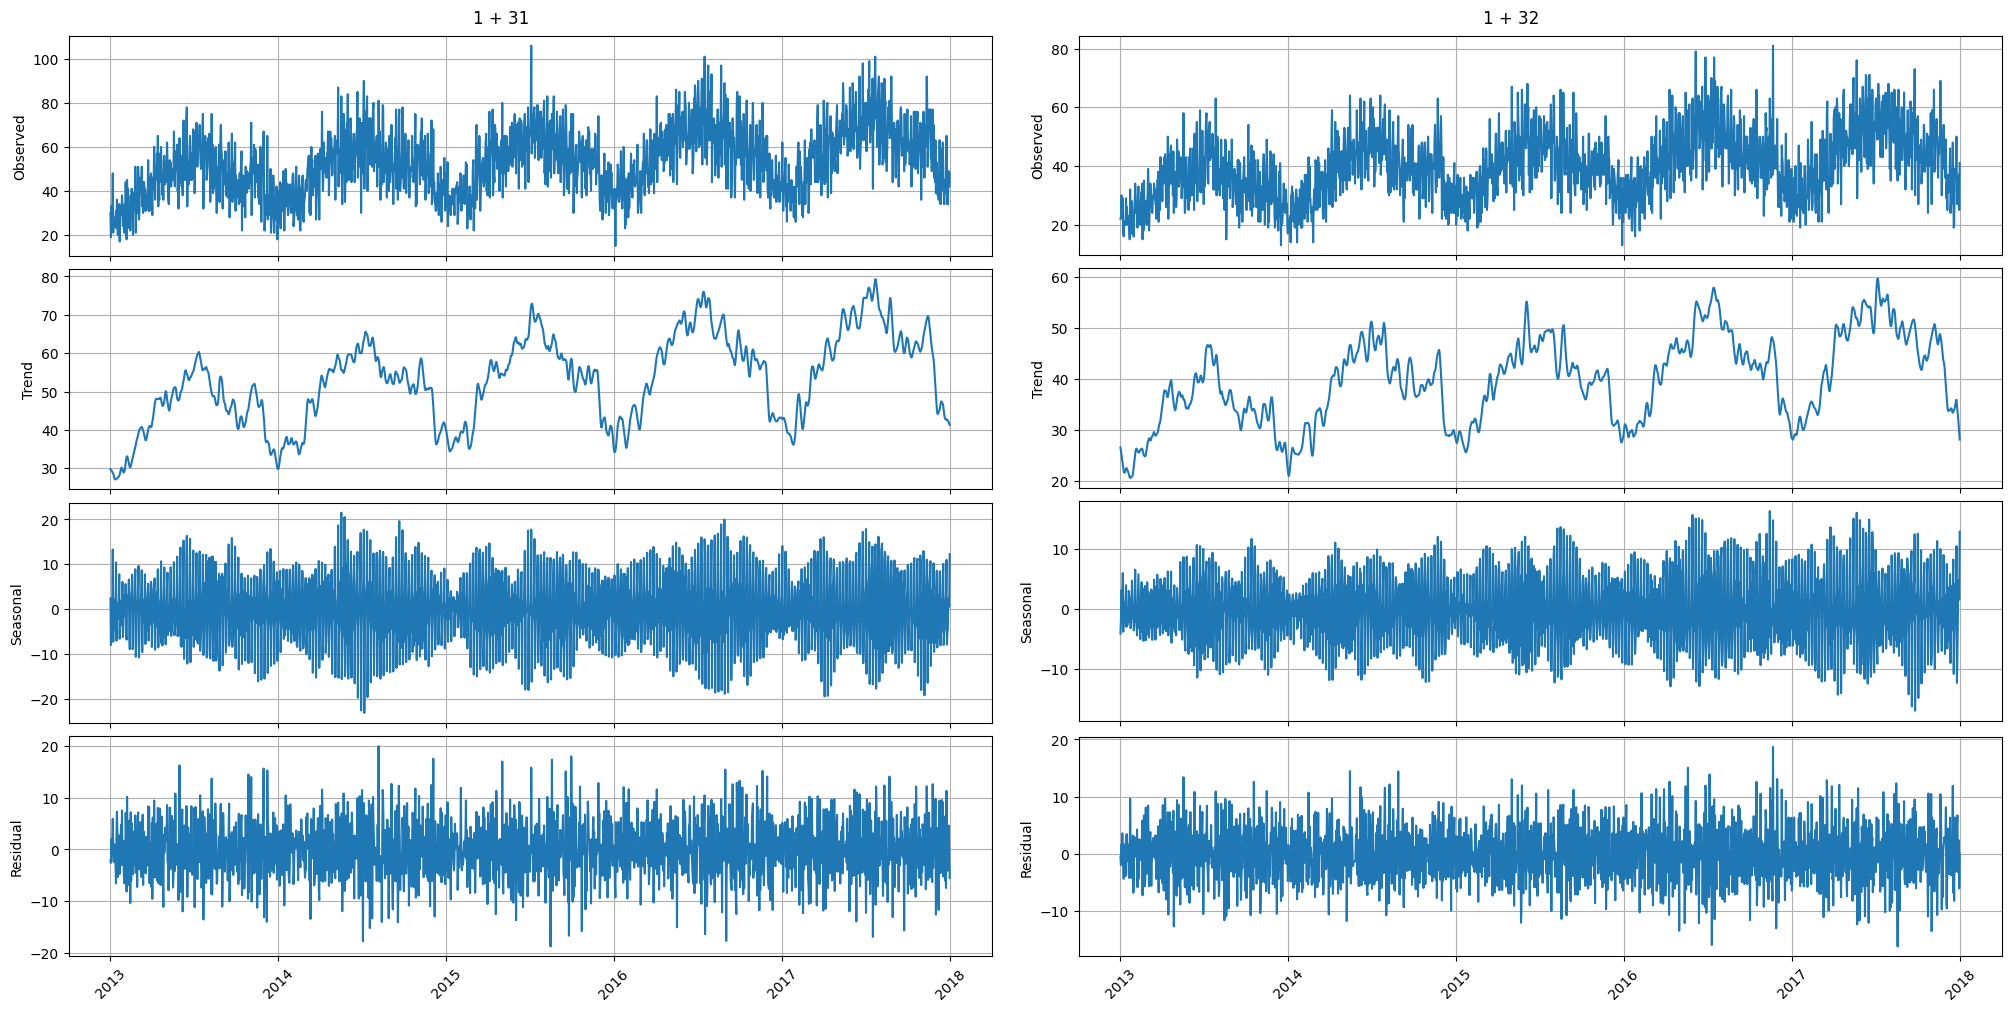

In [25]:
from etna.analysis import stl_plot

stl_plot(ts=ts, period=7, segments=['1 + 31', '1 + 32'])

# 1: Linear Model

In [26]:
from etna.transforms import MeanTransform, LagTransform, StandardScalerTransform
from etna.models import ElasticPerSegmentModel

standardscaler = StandardScalerTransform(in_column=None)

mean7 = MeanTransform(in_column='target', 
                      window=7, 
                      out_column='mean_7')

elast_transforms = [mean7, standardscaler]


linear_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0, 
                                 random_state=42),
    transforms=elast_transforms,
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    n_train_samples=0
    )

feature  store  item  quarter_end   quarter  quarter_start
0          0.0   0.0    -0.105194  1.437189      -0.107958
1          0.0   0.0    -0.105194  1.437189      -0.107958
2          0.0   0.0    -0.105194  1.437189      -0.107958
3          0.0   0.0    -0.105194  1.437189      -0.107958
4          0.0   0.0    -0.105194  1.437189      -0.107958
..         ...   ...          ...       ...            ...
85         0.0   0.0    -0.105194  1.437189      -0.107958
86         0.0   0.0    -0.105194  1.437189      -0.107958
87         0.0   0.0    -0.105194  1.437189      -0.107958
88         0.0   0.0    -0.105194  1.437189      -0.107958
89         0.0   0.0     9.506231  1.437189      -0.107958

[90 rows x 5 columns]
feature  store  item  quarter_end   quarter  quarter_start
0          0.0   0.0    -0.105194  1.437189      -0.107958
1          0.0   0.0    -0.105194  1.437189      -0.107958
2          0.0   0.0    -0.105194  1.437189      -0.107958
3          0.0   0.0    -0.105194

# 2: Prophet

In [34]:
from etna.models import ProphetModel

standart_prophet_metrics = train_and_evaluate_model(
    ts=ts,
    model=ProphetModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    n_train_samples=0
    )

11:26:59 - cmdstanpy - INFO - Chain [1] start processing
11:26:59 - cmdstanpy - INFO - Chain [1] done processing
11:26:59 - cmdstanpy - INFO - Chain [1] start processing
11:26:59 - cmdstanpy - INFO - Chain [1] done processing
11:27:00 - cmdstanpy - INFO - Chain [1] start processing
11:27:00 - cmdstanpy - INFO - Chain [1] done processing
11:27:00 - cmdstanpy - INFO - Chain [1] start processing
11:27:00 - cmdstanpy - INFO - Chain [1] done processing
11:27:00 - cmdstanpy - INFO - Chain [1] start processing
11:27:01 - cmdstanpy - INFO - Chain [1] done processing
11:27:01 - cmdstanpy - INFO - Chain [1] start processing
11:27:01 - cmdstanpy - INFO - Chain [1] done processing
11:27:01 - cmdstanpy - INFO - Chain [1] start processing
11:27:01 - cmdstanpy - INFO - Chain [1] done processing
11:27:02 - cmdstanpy - INFO - Chain [1] start processing
11:27:02 - cmdstanpy - INFO - Chain [1] done processing
11:27:02 - cmdstanpy - INFO - Chain [1] start processing
11:27:02 - cmdstanpy - INFO - Chain [1]

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 13.25777579325907


# 3: AutoARIMA

In [ ]:
from etna.models import AutoARIMAModel

AutoARIMA_metrics = train_and_evaluate_model(
    ts=ts,
    model=AutoARIMAModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    n_train_samples=0
    )

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 19.768461028223868


# 4: TBATS

In [ ]:
from etna.models import TBATSModel

# computation time is way too long
tbats_metrics = train_and_evaluate_model(
    ts=ts,
    model=TBATSModel(seasonal_periods=[7, 365], use_box_cox=True, n_jobs=8),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    n_train_samples=0
    )

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


# 5*. Default Catboost

In [ ]:
from etna.models.catboost import CatBoostMultiSegmentModel

In [ ]:
scaler = StandardScalerTransform(in_column='target')

lags = LagTransform(in_column='target', 
                    lags=[90, 120, 150, 180, 210, 240, 
                          270, 300, 330, 360], 
                    out_column='lag')

mean90 = MeanTransform(in_column='target', window=90, 
                        out_column='mean90')
mean180 = MeanTransform(in_column='target', window=180, 
                        out_column='mean180')
mean210 = MeanTransform(in_column='target', window=210, 
                        out_column='mean210')
mean240 = MeanTransform(in_column='target', window=240, 
                        out_column='mean240')
mean270 = MeanTransform(in_column='target', window=270, 
                        out_column='mean270')
mean360 = MeanTransform(in_column='target', window=360, 
                        out_column='mean360')

# создаем экземпляр класса DateFlagsTransform 
# для генерации признаков на основе дат
d_flags = DateFlagsTransform(day_number_in_year=True,
                             day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             season_number=True,
                             is_weekend=True,
                             out_column='datetime')

In [ ]:
preprocess = [scaler, lags, mean90, mean180, mean210, mean240, 
              mean270, mean360, d_flags]
catboost_model = CatBoostMultiSegmentModel()
                                   
catboost_metrics = train_and_evaluate_model(
    ts=ts,
    model=catboost_model,
    transforms=preprocess,
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    n_train_samples=0
    )

In [ ]:
catboost_metrics

(1 + 1     21.747019
 1 + 10    13.215848
 1 + 11    11.777976
 1 + 12    10.375218
 1 + 13    10.384584
             ...    
 9 + 50    10.569003
 9 + 6     10.146452
 9 + 7     12.052195
 9 + 8     10.063002
 9 + 9     12.878870
 Length: 500, dtype: float64,
 14.00236526448299)

# X + 1. LightGBM. 
Пример как использовать кастомную модель в etna

In [ ]:
# вот так самому можно реализовать модель для этны
# взято из: https://github.com/etna-team/etna/blob/2.4.0/examples/301-custom_transform_and_model.ipynb

from lightgbm import LGBMRegressor
from etna.pipeline import Pipeline

from etna.models.base import (BaseAdapter, 
                              NonPredictionIntervalContextIgnorantAbstractModel)

from etna.models.mixins import (PerSegmentModelMixin,
                                MultiSegmentModelMixin,
                                NonPredictionIntervalContextIgnorantModelMixin)


class _LGBMAdapter(BaseAdapter):
    def __init__(
        self,
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs
    ):
        self.model = LGBMRegressor(
            boosting_type=boosting_type,
            num_leaves=num_leaves,
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            **kwargs
        )
        self._categorical = None

    def fit(self, df: pd.DataFrame, regressors):
        df = df.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        features = df.drop(columns=['timestamp', 'target'])
        self._categorical = features.select_dtypes(
            include=['category']).columns.to_list()
        target = df['target']
        self.model.fit(X=features, y=target, 
                       categorical_feature=self._categorical)
        return self

    def predict(self, df: pd.DataFrame):
        features = df.drop(columns=['timestamp', 'target'])
        pred = self.model.predict(features)
        return pred
    
    def get_model(self) -> LGBMRegressor:
        return self.model

class LGBMMultiSegmentModel(
    MultiSegmentModelMixin,
    NonPredictionIntervalContextIgnorantModelMixin,
    NonPredictionIntervalContextIgnorantAbstractModel):

    def __init__(
        self,
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        super().__init__(
            base_model=_LGBMAdapter(
                boosting_type=boosting_type,
                num_leaves=num_leaves,
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                **kwargs
            )
        )


In [ ]:
# задаем список преобразований/признаков
preprocess = [scaler, lags, mean90, mean180, mean210, mean240, 
              mean270, mean360, d_flags]

# задаем горизонт прогнозирования
HORIZON = 90

# создаем экземпляр класса SMAPE
smape = SMAPE()

# создаем модель LGBMMultiSegmentModel
lgbm_model = LGBMMultiSegmentModel(n_estimators=150, 
                                   learning_rate=0.1,
                                   num_leaves=10,
                                   min_data_in_leaf=120,
                                   subsample=0.8)

                                   
lgbm_metrics = train_and_evaluate_model(
    ts=ts,
    model=lgbm_model,
    transforms=preprocess,
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    n_train_samples=0
    )
    

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4634
[LightGBM] [Info] Number of data points in the train set: 688000, number of used features: 29
[LightGBM] [Info] Start training from score 0.145972
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in

## Conclusion

In [ ]:
linear_model_metrics, AutoARIMA_metrics, standart_prophet_metrics, lgbm_metrics, catboost_metrics

((1 + 1     24.456839
  1 + 10    18.792293
  1 + 11    19.512474
  1 + 12    16.927626
  1 + 13    18.353744
              ...    
  9 + 50    17.037359
  9 + 6     18.196012
  9 + 7     17.036181
  9 + 8     18.096401
  9 + 9     18.395560
  Length: 500, dtype: float64,
  19.73216390825046),
 (1 + 1     24.456809
  1 + 10    18.792331
  1 + 11    19.512477
  1 + 12    16.927627
  1 + 13    18.353780
              ...    
  9 + 50    17.037541
  9 + 6     18.474788
  9 + 7     17.208460
  9 + 8     18.461150
  9 + 9     18.497439
  Length: 500, dtype: float64,
  19.768461028223868),
 (1 + 1     19.804758
  1 + 10    11.628842
  1 + 11    11.705745
  1 + 12     9.509008
  1 + 13    10.739509
              ...    
  9 + 50    10.523020
  9 + 6     10.529946
  9 + 7     10.544880
  9 + 8     10.429094
  9 + 9     12.353598
  Length: 500, dtype: float64,
  13.25777579325907),
 (1 + 1     20.205943
  1 + 10    10.511213
  1 + 11    11.090843
  1 + 12     8.531873
  1 + 13     9.122091
    

### Predictions Analysis

In [ ]:
# function that found worst segment
def found_worst_seg(metrics):
    worst = metrics.idxmax()
    return worst, metrics[worst]


print('worst for linear model', found_worst_seg(linear_model_metrics[0]))
print('worst for AutoARIMA', found_worst_seg(AutoARIMA_metrics[0]))
print('worst for standart_prophet', found_worst_seg(standart_prophet_metrics[0]))
print('worst for lgbm', found_worst_seg(lgbm_metrics[0]))
print('worst for catboost', found_worst_seg(catboost_metrics[0]))


worst for linear model ('7 + 27', 29.588013638398415)
worst for AutoARIMA ('7 + 27', 29.798151654345233)
worst for standart_prophet ('7 + 27', 25.023063389980425)
worst for lgbm ('7 + 27', 23.43791166347711)
worst for catboost ('7 + 27', 26.906437435205504)


In [ ]:
metric_res = pd.DataFrame(columns=['model', 'avg SMAPE', 'worst_segment', 'worst_metric'])

for model, metrics in zip(['AutoARIMA', 'standart_prophet', 'lgbm', 'catboost'], 
                          [AutoARIMA_metrics, standart_prophet_metrics, lgbm_metrics, catboost_metrics]):
    
    metric_res = metric_res.append({'model': model, 
                                    'avg SMAPE': metrics[1], 
                                    'worst_segment': found_worst_seg(metrics[0])[0],
                                    'worst_metric': found_worst_seg(metrics[0])[1],
                                    }, ignore_index=True)

In [ ]:
metric_res

,model,avg SMAPE,worst_segment,worst_metric
0,AutoARIMA,19.768461,7 + 27,29.798152
1,standart_prophet,13.257776,7 + 27,25.023063
2,lgbm,12.272729,7 + 27,23.437912
3,catboost,14.002365,7 + 27,26.906437


In [ ]:
# plot 7 + 27 segment
from etna.analysis import plot_forecast


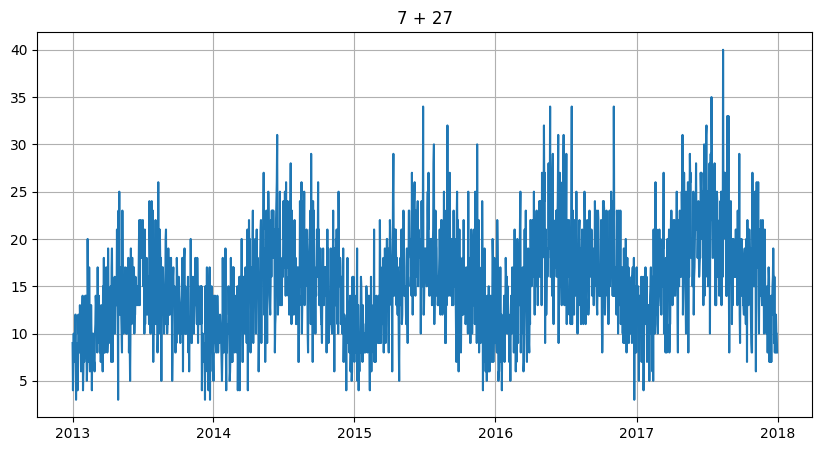

In [ ]:
ts.plot(segments=['7 + 27'])

In [ ]:
_, _, forecast = train_and_evaluate_model(
    ts=ts,
    model=lgbm_model,
    transforms=preprocess,
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    return_forecast=True,
    n_train_samples=0
    )
    

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4634
[LightGBM] [Info] Number of data points in the train set: 688000, number of used features: 29
[LightGBM] [Info] Start training from score 0.145972
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in

In [ ]:
# choose seg==7 + 27
forecast.to_pandas(flatten=True)[forecast.to_pandas(flatten=True).segment.eq('7 + 27')]

,timestamp,segment,target,datetime_day_number_in_month,datetime_day_number_in_week,datetime_day_number_in_year,datetime_is_weekend,datetime_month_number_in_year,datetime_season_number,datetime_week_number_in_month,...,mean180,mean210,mean240,mean270,mean360,mean90,quarter,quarter_end,quarter_start,store
33210,2017-10-03,7 + 27,15.205805,3,1,277,False,10,4,2,...,0.876332,0.770752,0.652111,0.506525,0.383937,0.866162,4,False,False,7
33211,2017-10-04,7 + 27,15.064931,4,2,278,False,10,4,2,...,0.874335,0.774655,0.655023,0.515354,0.381060,0.866138,4,False,False,7
33212,2017-10-05,7 + 27,16.369540,5,3,279,False,10,4,2,...,0.872314,0.775960,0.656426,0.518119,0.382752,0.857753,4,False,False,7
33213,2017-10-06,7 + 27,18.124512,6,4,280,False,10,4,2,...,0.870271,0.776395,0.663234,0.523640,0.385475,0.861861,4,False,False,7
33214,2017-10-07,7 + 27,18.848004,7,5,281,True,10,4,2,...,0.876518,0.776834,0.669326,0.527830,0.387189,0.844671,4,False,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33295,2017-12-27,7 + 27,10.759580,27,2,362,False,12,1,5,...,0.883682,0.942999,0.904812,0.862275,0.485250,0.413571,4,False,False,7
33296,2017-12-28,7 + 27,12.088326,28,3,363,False,12,1,5,...,0.860383,0.943608,0.910994,0.860255,0.489843,0.625733,4,False,False,7
33297,2017-12-29,7 + 27,12.828260,29,4,364,False,12,1,5,...,0.858321,0.939754,0.910079,0.864208,0.494469,0.504497,4,False,False,7
33298,2017-12-30,7 + 27,14.367452,30,5,365,True,12,1,5,...,0.866206,0.937339,0.901926,0.871219,0.499129,0.322644,4,False,False,7


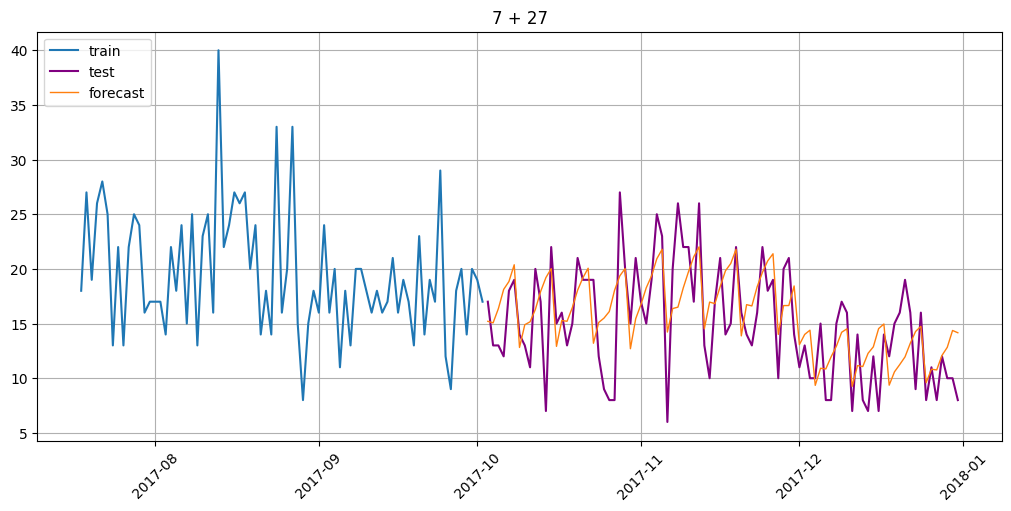

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

plot_forecast(forecast,
              segments=['7 + 27'],
              train_ts=train_ts, test_ts=test_ts, n_train_samples=77)


## Отправка на Kaggle 

Пример как подготовить ряд к нужному формута для отправки на кегл

In [ ]:
# 1. выполняем преобразования всего исторического набора
ts.fit_transform(preprocess)

lgbm_model.fit(ts)

# формируем набор, для которого нужно получить прогнозы
future_ts = ts.make_future(HORIZON, preprocess)

forecast_ts = lgbm_model.forecast(future_ts)

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4635
[LightGBM] [Info] Number of data points in the train set: 733000, number of used features: 29
[LightGBM] [Info] Start training from score 0.139888
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in

In [ ]:
# выполняем обратные преобразования прогнозов
forecast_ts.inverse_transform(preprocess)

In [ ]:
# превращаем в обычный плоский датафрейм
forecast_ts = forecast_ts.to_pandas(flatten=True)
forecast_ts

,timestamp,segment,target,datetime_day_number_in_month,datetime_day_number_in_week,datetime_day_number_in_year,datetime_is_weekend,datetime_month_number_in_year,datetime_season_number,datetime_week_number_in_month,...,mean180,mean210,mean240,mean270,mean360,mean90,quarter,quarter_end,quarter_start,store
0,2018-01-01,1 + 1,12.386836,1,0,1,False,1,1,1,...,0.460990,0.568661,0.600874,0.584531,0.342744,0.054243,1,False,True,1
1,2018-01-02,1 + 1,13.545542,2,1,2,False,1,1,1,...,0.454386,0.569948,0.596523,0.583928,0.346177,0.063243,1,False,False,1
2,2018-01-03,1 + 1,14.046160,3,2,3,False,1,1,1,...,0.446869,0.566229,0.596518,0.584432,0.347135,0.063921,1,False,False,1
3,2018-01-04,1 + 1,15.065521,4,3,4,False,1,1,1,...,0.443482,0.564635,0.591482,0.586613,0.348932,0.066341,1,False,False,1
4,2018-01-05,1 + 1,15.722668,5,4,5,False,1,1,1,...,0.435817,0.570264,0.595876,0.589371,0.353664,0.063580,1,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,9 + 9,50.461775,27,1,87,False,3,2,5,...,0.131325,0.228783,0.379544,0.562556,0.718444,-0.089464,1,False,False,9
44996,2018-03-28,9 + 9,51.939017,28,2,88,False,3,2,5,...,0.120750,0.222652,0.379913,0.559538,0.718684,0.015022,1,False,False,9
44997,2018-03-29,9 + 9,55.691843,29,3,89,False,3,2,5,...,0.110661,0.219666,0.378985,0.550685,0.723535,0.026021,1,False,False,9
44998,2018-03-30,9 + 9,59.515447,30,4,90,False,3,2,5,...,0.108328,0.209541,0.379793,0.553401,0.724526,-0.270939,1,False,False,9


In [ ]:
# формируем датафрейм для посылки
subm = (
    df_new.drop(['store', 'item'], axis=1).merge(forecast_ts, on=['timestamp', 'segment'])['target'].reset_index()
    .rename({'index': 'id', 'target': 'sales'}, axis=1)
    )
subm

,id,sales
0,0,12.386836
1,1,13.545542
2,2,14.046160
3,3,15.065521
4,4,15.722668
...,...,...
44995,44995,69.409367
44996,44996,71.488139
44997,44997,76.271906
44998,44998,81.475180


In [ ]:
subm.to_csv('kaggle_store_item_demand_submission.csv', 
            index=False)

# Backtest

In [ ]:
pipe = Pipeline(
    model=lgbm_model,
    transforms=preprocess,
    horizon=HORIZON)
        
metrics_df, _, _ = pipe.backtest(
    mode='expand', 
    n_folds=4,
    ts=ts, 
    metrics=[smape], 
    aggregate_metrics=True,
    joblib_params=dict(backend='loky'))


In [ ]:
metrics_df.head(8)
metric = metrics_df['SMAPE'].mean()

In [ ]:

print(f'mean SMAPE: {metric:.4f}')